<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://raw.githubusercontent.com/Unidata/MetPy/master/src/metpy/plots/_static/unidata_150x150.png" alt="Unidata Logo" style="height: 98px;">
</div>

<h1>Advanced MetPy: Isentropic Analysis</h1>
    <h3>AMS 2022 Short Course: MetPy for Quantitative Analysis of Meteorological Data</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

### Tasks
1. <a href="#download">Access GFS output from a THREDDS Data Server (TDS)</a>
1. <a href="#interpolation">Isentropic interpolation</a>
1. <a href="#ascent">Calculate isentropic ascent ($\omega$)</a>
1. <a href="#mixingratio">Calculate mixing ratio</a>


### Background
Up until this point, we have been examining data on constant pressure (isobaric) surfaces, which aligns with how meteorological data are typically written and served. However, we know there are several benefits for examining data on constant potential temperature (isentropic) surfaces including diagnosing vertical motion through advection of pressure, locating airmass boundaries in a conveyor belts framework, depicting the dynamic tropopause and tropopause folds, among <a href="https://www.meted.ucar.edu/labs/synoptic/isentropic_analysis/print.php" target="blank">others</a>. 

<center><img src="https://elearning.unidata.ucar.edu/metpy/AMS2022/thetaxsect2.png" width="800px"/><br>
<i>Vertical cross-section of potential temperature</i><br>
<i>An isentropic chart uses an isentrope as its base level</i></center><br>


In this lesson, we will demonstrate how to use built-in MetPy functions to easily interpolate variables on isobaric surfaces to isentropic surfaces. 

<a name="download"></a>
## Step 1: Access GFS Output
We will perform the isentropic interpolation in this lesson on the latest run of the GFS available on [Unidata's THREDDS data server](https://thredds.ucar.edu/). First, we access the catalog for the half-degree GFS output, and look for the dataset called the "[Best GFS Half Degree Forecast Time Series](https://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p5deg/catalog.html?dataset=grib/NCEP/GFS/Global_0p5deg/Best)". This dataset combines multiple sets of model runs to yield a time series of output with the shortest forecast offset.

In [1]:
from siphon.catalog import TDSCatalog

cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/'
                 'NCEP/GFS/Global_0p5deg/catalog.xml')
best = cat.datasets['Best GFS Half Degree Forecast Time Series']

Next, we use the [NetCDF Subset Service (NCSS)](https://www.unidata.ucar.edu/software/tds/current/reference/NetcdfSubsetServiceReference.html) to make requests from the GRIB collection and get results in netCDF format.

In [2]:
subset_access = best.subset()
query = subset_access.query()

GFS output contains [many variables](https://thredds.ucar.edu/thredds/ncss/grib/NCEP/GFS/Global_0p25deg/Best/dataset.html). In fact, too many to search for all the variables we need for this interpolation. Instead of printing `subset_access.variables` and listing all 150+ variable names, we can ask Python to only display variables that end with "isobaric". This suffix is how the TDS denotes GRIB fields that are specified on isobaric levels.

In [3]:
sorted(v for v in subset_access.variables if v.endswith('isobaric'))

['Absolute_vorticity_isobaric',
 'Cloud_mixing_ratio_isobaric',
 'Geopotential_height_isobaric',
 'Graupel_snow_pellets_isobaric',
 'Ice_water_mixing_ratio_isobaric',
 'Ozone_Mixing_Ratio_isobaric',
 'Rain_mixing_ratio_isobaric',
 'Relative_humidity_isobaric',
 'Snow_mixing_ratio_isobaric',
 'Specific_humidity_isobaric',
 'Temperature_isobaric',
 'Total_cloud_cover_isobaric',
 'Vertical_velocity_geometric_isobaric',
 'Vertical_velocity_pressure_isobaric',
 'u-component_of_wind_isobaric',
 'v-component_of_wind_isobaric']

#### Query the TDS

Now we put together the query to send to the TDS. Recall that we can query for a bounding box and time in addition to the variables we need. 

In this example, we'll query for data across the contenental US and for the time step closest to now. We also request **temperature**, **height**, **winds**, and **relative humidity**. By asking for netCDF4 data, the result is compressed, so the download is smaller.

In [4]:
from datetime import datetime
dt = datetime.utcnow()
query.time(dt)
query.variables('Temperature_isobaric', 'Geopotential_height_isobaric',
                'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric',
                'Relative_humidity_isobaric')
query.lonlat_box(west=-130, east=-50, south=10, north=60)
query.accept('netcdf4')

var=Relative_humidity_isobaric&var=v-component_of_wind_isobaric&var=Temperature_isobaric&var=u-component_of_wind_isobaric&var=Geopotential_height_isobaric&time=2022-03-14T22%3A57%3A58.415884&west=-130&east=-50&south=10&north=60&accept=netcdf4

Now all that's left is to actually make the request for data.

In [5]:
nc = subset_access.get_data(query)

#### Open and examine data

Now we can open and review the returned netCDF data using XArray. Notice the dimensions each of the variables have. 

In [6]:
from xarray.backends import NetCDF4DataStore
import xarray as xr
ds = xr.open_dataset(NetCDF4DataStore(nc))
ds

<xarray.Dataset>
Dimensions:                       (time: 1, isobaric1: 41, lat: 101, lon: 161)
Coordinates:
    reftime                       (time) datetime64[ns] ...
  * time                          (time) datetime64[ns] 2022-03-15
  * isobaric1                     (isobaric1) float32 1.0 2.0 ... 9.75e+04 1e+05
  * lat                           (lat) float32 60.0 59.5 59.0 ... 10.5 10.0
  * lon                           (lon) float32 230.0 230.5 ... 309.5 310.0
Data variables:
    Relative_humidity_isobaric    (time, isobaric1, lat, lon) float32 ...
    LatLon_Projection             int32 ...
    v-component_of_wind_isobaric  (time, isobaric1, lat, lon) float32 ...
    Temperature_isobaric          (time, isobaric1, lat, lon) float32 ...
    u-component_of_wind_isobaric  (time, isobaric1, lat, lon) float32 ...
    Geopotential_height_isobaric  (time, isobaric1, lat, lon) float32 ...
Attributes: (12/13)
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    Conventions:                                                             ...
    ...                                                                                ...
    featureType:                                                             ...
    History:                                                                 ...
    geospatial_lat_min:                                                      ...
    geospatial_lat_max:                                                      ...
    geospatial_lon_min:                                                      ...
    geospatial_lon_max:                                                      ...

Since we are working with only one time, we can use `squeeze()` to remove time as a dimension from the dataset. In the same step, we can also parse out the metadata for the isobaric temperature and get the projection information with `parse_cf()`.

In [7]:
import metpy
ds = ds.metpy.parse_cf().squeeze()
ds

<xarray.Dataset>
Dimensions:                       (isobaric1: 41, lat: 101, lon: 161)
Coordinates:
    reftime                       datetime64[ns] 2022-03-14T12:00:00
    time                          datetime64[ns] 2022-03-15
  * isobaric1                     (isobaric1) float32 1.0 2.0 ... 9.75e+04 1e+05
  * lat                           (lat) float32 60.0 59.5 59.0 ... 10.5 10.0
  * lon                           (lon) float32 230.0 230.5 ... 309.5 310.0
    metpy_crs                     object Projection: latitude_longitude
Data variables:
    Relative_humidity_isobaric    (isobaric1, lat, lon) float32 ...
    LatLon_Projection             int32 0
    v-component_of_wind_isobaric  (isobaric1, lat, lon) float32 ...
    Temperature_isobaric          (isobaric1, lat, lon) float32 ...
    u-component_of_wind_isobaric  (isobaric1, lat, lon) float32 ...
    Geopotential_height_isobaric  (isobaric1, lat, lon) float32 ...
Attributes: (12/13)
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    Conventions:                                                             ...
    ...                                                                                ...
    featureType:                                                             ...
    History:                                                                 ...
    geospatial_lat_min:                                                      ...
    geospatial_lat_max:                                                      ...
    geospatial_lon_min:                                                      ...
    geospatial_lon_max:                                                      ...

<a name="interpolation"></a>
## Step 2: Isentropic Interpolation

We can now use MetPy to interpolate the data we've just accessed to an isentropic surface and visualize it on a map. To transform our variables from the pressure vertical coordinate to a constant potential temperature (isentropic) vertical coordinate, we can use the <a href="https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.isentropic_interpolation.html" target="blank">`isentropic_interpolation`</a> function. Since we have several variables to interpolate, we can also use the <a href="https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.isentropic_interpolation_as_dataset.html" target="blank">`isentropic_interpolation_as_dataset`</a> function to organize all outputs into an xarray Dataset. 

First, we import the required packages for this analysis.

In [8]:
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np

Next, we perform the isentropic interpolation. For this, we will use [`isentropic_interpolation_as_dataset`](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.isentropic_interpolation_as_dataset.html). At a minimum, this must be given one or more isentropic levels and the 3-D temperature field. It then returns the 3D array of pressure values (2D slices for each isentropic level). This relies on getting the pressure values from the passed in temperature. 

There is also a version of this function, [`isentropic_interpolation`](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.isentropic_interpolation.html), that returns individual arrays rather than an xarray dataset.

You can also pass additional fields which will be interpolated to these levels as well. Below, we interpolate the winds (and pressure) to the 320 K isentropic level:

In [9]:
isen_level = np.array([320]) * units.kelvin
isen_ds = mpcalc.isentropic_interpolation_as_dataset(isen_level, ds.Temperature_isobaric,
                                                     ds['u-component_of_wind_isobaric'],
                                                     ds['v-component_of_wind_isobaric'])

# Squeeze the single isentropic level to return a 2D array for plotting
isen_ds = isen_ds.metpy.parse_cf().squeeze()
isen_ds

Magnitude,[[261.51495361328125 260.7820129394531 261.2471008300781 ... 265.49432373046875 265.5282897949219 265.0839538574219] [263.63330078125 263.660400390625 263.3014221191406 ... 266.42864990234375 267.1338195800781 267.3105163574219] [268.4154357910156 268.5257263183594 269.17333984375 ... 269.1330871582031 268.5442810058594 268.65997314453125] ... [547.6119384765625 542.768310546875 557.3422241210938 ... 567.597900390625 566.386962890625 561.4827270507812] [546.53173828125 556.4619750976562 563.8761596679688 ... 559.0172119140625 560.7872924804688 559.2088012695312] [534.547607421875 560.2357177734375 558.7656860351562 ... 559.8395385742188 562.6865844726562 556.2466430664062]]
Units,hectopascal
Magnitude,[[218.1325251469356 217.95766057740596 218.0686607835982 ... 219.07575951466276 219.0837697018765 218.9789505327118] [218.63590356498048 218.64231445490117 218.55722271629932 ... 219.29576959666426 219.46143070116597 219.5029030412673] [219.76174554885696 219.78754820727323 219.93886933088012 ... 219.92946309150977 219.79188523204263 219.8189370128325] ... [269.4188347468259 268.735822028281 270.7780107263962 ... 272.19233628307995 272.02631213064944 271.35123354493373] [269.26687131857034 270.6557534075031 271.6812041781965 ... 271.01027037679586 271.25518072919806 271.03681312501124] [267.5665336818681 271.1789188865919 270.975416973459 ... 271.1241124862928 271.5173407276634 270.6258202009605]]
Units,kelvin
Magnitude,[[14.47587535319257 14.444141720993699 15.06659796064458 ... 13.000650553460103 13.263572002960604 13.472235342916742] [13.057362536367613 13.671041052163046 14.016296831067454 ... 14.521505324747318 14.508274825884483 14.189872135885507] [11.897362307402958 12.21580702335239 12.520817801918117 ... 15.487414585269622 15.384484923473039 15.482854945440138] ... [-11.577454676770245 -13.614665880520425 -13.658346631574513 ... 9.125565757256156 9.926073195495668 11.801524674889222] [-12.49879793725468 -13.611950131525733 -13.577229401664159 ... 9.470653277766168 10.951084274294702 12.02549286739811] [-13.875704627656328 -12.609076827139287 -13.887026316634968 ... 10.240205186071272 11.377441618529009 11.947857097782595]]
Units,meter/second
Magnitude,[[1.7743642839826217 1.791557523127739 2.1402751286558495 ... 9.150307498976007 8.950940638687316 8.834720402950161] [2.386946393721415 2.2299724690857547 2.0768947036288288 ... 9.300017309175534 9.325316545868883 9.128321062046663] [2.3455144529446623 2.4475470077529136 2.15630846348778 ... 9.432428869456098 9.666833115213251 9.460076501417523] ... [2.7995158882815065 3.3160646125109605 2.9776429368961774 ... -2.0718563245883064 -2.031766539436116 -1.838711449438471] [3.835606049292352 3.7907711064747622 2.55927129606744 ... -1.921973799092069 -2.018681355666872 -2.256264606078277] [4.688042128577074 2.8839713490246806 2.2322520193304984 ... -1.3133399397354224 -0.24033373784936574 -2.163440117392482]]
Units,meter/second


#### Plot results

Let's now preview our data on the 320 K isentropic surface. 

In [10]:
# Pull out pressure and wind (u and v) arrays from the dataset
isen_press = isen_ds.pressure
isen_u = isen_ds['u-component_of_wind_isobaric']
isen_v = isen_ds['v-component_of_wind_isobaric']

# Pull the projection for the plot
data_proj = isen_press.metpy.cartopy_crs

# Add lat/lon to pressure array
lon = isen_press.metpy.longitude
lat = isen_press.metpy.latitude

isen_press

Magnitude,[[261.51495361328125 260.7820129394531 261.2471008300781 ... 265.49432373046875 265.5282897949219 265.0839538574219] [263.63330078125 263.660400390625 263.3014221191406 ... 266.42864990234375 267.1338195800781 267.3105163574219] [268.4154357910156 268.5257263183594 269.17333984375 ... 269.1330871582031 268.5442810058594 268.65997314453125] ... [547.6119384765625 542.768310546875 557.3422241210938 ... 567.597900390625 566.386962890625 561.4827270507812] [546.53173828125 556.4619750976562 563.8761596679688 ... 559.0172119140625 560.7872924804688 559.2088012695312] [534.547607421875 560.2357177734375 558.7656860351562 ... 559.8395385742188 562.6865844726562 556.2466430664062]]
Units,hectopascal


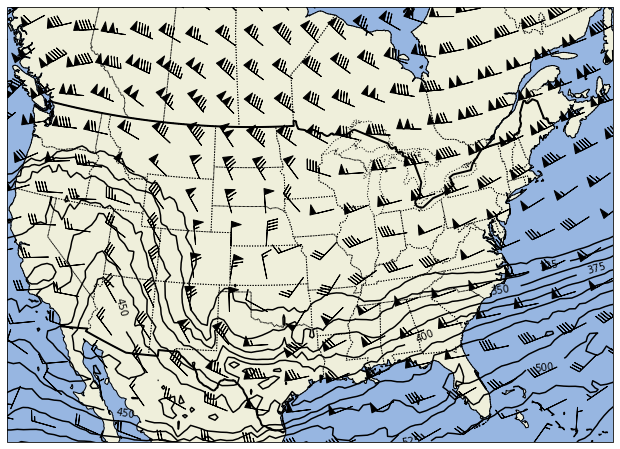

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a plot and basic map projection
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal(central_longitude=-100))

# Contour the pressure values for the isentropic level. We keep the handle
# for the contour so that we can have matplotlib label the contours
levels = np.arange(300, 1000, 25)
cntr = ax.contour(lon, lat, isen_press, transform=data_proj,
                  colors='black', levels=levels)
cntr.clabel(fmt='%d')

# Set up slices to subset the wind barbs--the slices below are the same as `::7` and `::5`
# We put these here so that it's easy to change and keep all of the ones below matched
# up.
lon_slice = slice(None, None, 7)
lat_slice = slice(None, None, 5)
ax.barbs(lon[lon_slice], lat[lat_slice],
         isen_u[lat_slice, lon_slice].metpy.convert_units('knots').to_numpy(),
         isen_v[lat_slice, lon_slice].metpy.convert_units('knots').to_numpy(),
         transform=data_proj, zorder=2)

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=2)
ax.add_feature(cfeature.STATES, linestyle=':')

ax.set_extent((-120, -70, 25, 55), crs=data_proj)

<a name="ascent"></a>
## Step 3: Calculate Isentropic Ascent ($\omega$)

Air flow across isobars on an isentropic surface represents vertical motion. Isentropic ascent. $\omega$ is represented by:

$$\omega = \left(\frac{\partial P}{\partial t}\right)_\theta + \vec{V} \cdot \nabla_\theta P + \frac{\partial P}{\partial \theta}\frac{d\theta}{dt}$$

However, in practice we often represent $\omega$ just by the second term, the negated advection of Pressure across isentropic surfaces. We use the frozen wave approximation to remove the first term on the right hand side, and we assume that the phase speed of the system is much smaller than windspeed on the isentropic surface to eliminate the third term on the right hand side. In this example, we will calculate $\omega$ as just the second term, rewritten as:

$$-(-\vec{V} \cdot \nabla_\theta P)$$

Since calculating this involves taking derivatives, first let's smooth the input fields using a gaussian_filter.

In [12]:
isen_press = mpcalc.smooth_gaussian(isen_press, 9)
isen_u = mpcalc.smooth_gaussian(isen_u, 9)
isen_v = mpcalc.smooth_gaussian(isen_v, 9)

<div class="alert alert-success">
    <b>EXERCISE</b>: Calculate $\omega$

With the above arrays and assumptions previously made:
<ol>
    <li>Calculate $\omega$ as a variable called <code>lift</code></li>
    <li>Check the units of the output array to ensure that the result is a velocity</li>
</ol>
   
</div>

In [13]:
# YOUR CODE HERE

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

In [14]:
lift = -mpcalc.advection(isen_press, isen_u, isen_v)
lift.data.units

C:\Users\ncorbin\.conda\envs\pyaos-ams-2022\lib\site-packages\metpy\xarray.py:1468: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  warnings.warn(


<Unit('hectopascal / second')>

### Plot

With the `lift` variable calculated, plot it on an isentropic surface along with winds and pressure contours

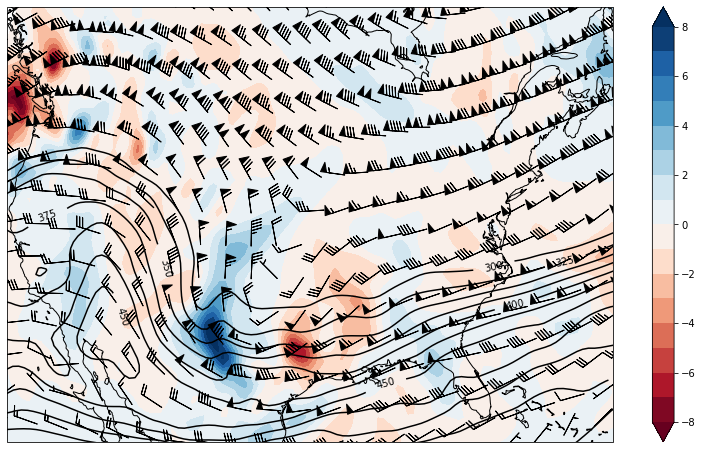

In [15]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal(central_longitude=-100))
ax.add_feature(cfeature.COASTLINE)

levels = np.arange(300, 1000, 25)
cntr = ax.contour(lon, lat, isen_press, transform=data_proj, colors='black', levels=levels)
cntr.clabel(fmt='%d')


lon_slice = slice(None, None, 5)
lat_slice = slice(None, None, 5)
ax.barbs(lon[lon_slice], lat[lat_slice],
         isen_u[lon_slice, lat_slice].metpy.convert_units('knots').to_numpy(),
         isen_v[lon_slice, lat_slice].metpy.convert_units('knots').to_numpy(),
         transform=data_proj, zorder=2)


levels = np.arange(-8, 9)
# Convert the units to microbar/s to better visualize on the plot
cs = ax.contourf(lon, lat, lift.metpy.convert_units('microbar/s').to_numpy(), levels=levels, cmap='RdBu',
                 transform=data_proj, extend='both')
plt.colorbar(cs)


ax.set_extent((-120, -70, 25, 55), crs=data_proj)

<a name="mixingratio"></a>
## Step 4: Calculate mixing ratio

Isentropic charts are often used for visualizing moisture transport, such as in warm conveyor belt systems. We can check for the presence of moisture transport by adding mixing ratio to our isentropic charts. 

<div class="alert alert-success">
    <b>EXERCISE</b>: Calculate mixing ratio
    
In this exercise you will calculate mixing ratio and visualize it on a plot similar to the ones above. 
    
This process includes several tasks:
    
 <ol>
     <li>Calculate the mixing ratio using an appropriate function from mpcalc. See: <a href="https://unidata.github.io/MetPy/latest/api/index.html" target="blank">MetPy Documentation</a></li>
     <li>Interpolate mixing ratio to an isentropic surface using the same method as previous. You may continue to use the 320 K level or another level of your choice.</li>
     <li>Use contour() or contourf() as used in previous examples to display mixing ratio alongside winds and pressure on a map.</li>
</ol>
    
Hints:
    
<ul>
    <li>Recall the variables we pulled from the TDS in the <code>ds</code> DataSet previously.</li>
    <li>Calculate mixing ratio with isobaric levels first, then interpolate to an isentropic level as in the <a href="#interpolation">Isentropic Interpolation</a> section above. </li>
    <li>If you need a pressure array, pull the vertical coordinate from one of the isobaric variables in the <code>ds</code> DataSet, <br>e.g. <code>pressure = ds.Temperature_isobaric.metpy.vertical</code></li>
    <li>If using <code>isentropic_interpolation_as_dataset</code> for the mixing ratio interpolation, be sure to add a <code>name</code> property to the DataArray first<br>e.g. <code>mixing.name = 'mixing_ratio'</code>
    <li>Remember to <code>squeeze</code> any arrays to plot to just two dimensions.</li>
    <li>If your final plot does not include much area of >1 mixing ratio, try interpolating to another isentropic level.</li>
    </ul>
</div>

In [16]:
# YOUR CODE HERE (Calculations)

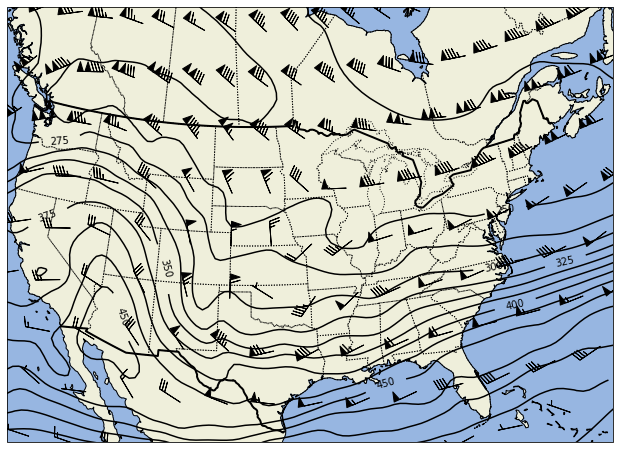

In [17]:
# YOUR CODE HERE (Plotting)
# Previous plotting code is copied here for you to start

# Create figure
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal(central_longitude=-100))

# Pressure contours
levels = np.arange(200, 1000, 25)
cntr = ax.contour(lon, lat, isen_press, transform=data_proj,
                  colors='black', levels=levels)
cntr.clabel(fmt='%d')

# Wind barbs
lon_slice = slice(None, None, 8)
lat_slice = slice(None, None, 8)
ax.barbs(lon[lon_slice], lat[lat_slice],
         isen_u[lat_slice, lon_slice].metpy.convert_units('knots').to_numpy(),
         isen_v[lat_slice, lon_slice].metpy.convert_units('knots').to_numpy(),
         transform=data_proj, zorder=2)



# Mixing ratio
# 
# YOUR CODE: Contour/Contourf the mixing ratio values
# 
# 


# Geographic context
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=2)
ax.add_feature(cfeature.STATES, linestyle=':')

# Set axes extent
ax.set_extent((-120, -70, 25, 55), crs=data_proj)

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

In [18]:
# Calculations

# Grab pressure from the temperature data array since it's the corresponding vertical coordinate
pressure = ds.Temperature_isobaric.metpy.vertical

# Calculate mixing ratio using something from mpcalc
mixing = mpcalc.mixing_ratio_from_relative_humidity(pressure, ds.Temperature_isobaric, ds.Relative_humidity_isobaric)

# Assign mixing a name for use in creating a new dataset during interpolation
mixing.name = 'mixing_ratio'

# Interpolate all the data
isen_level = np.array([310]) * units.kelvin
isen_ds = mpcalc.isentropic_interpolation_as_dataset(isen_level, ds.Temperature_isobaric,
                                                     ds['u-component_of_wind_isobaric'],
                                                     ds['v-component_of_wind_isobaric'],
                                                     mixing)

# Squeeze the result
isen_ds = isen_ds.squeeze()

C:\Users\ncorbin\.conda\envs\pyaos-ams-2022\lib\site-packages\metpy\interpolate\one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')


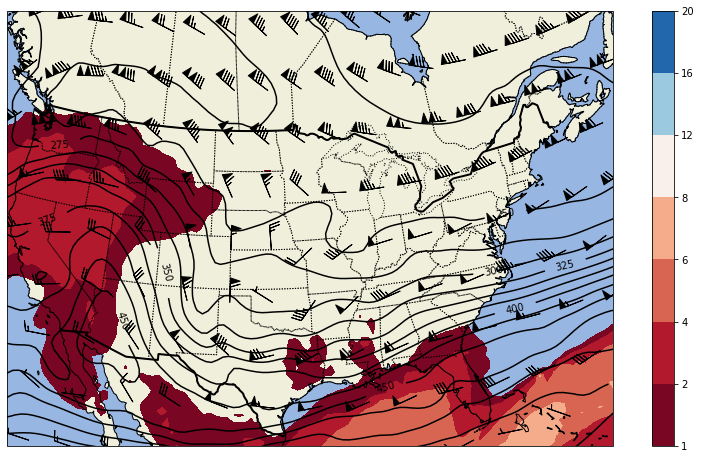

In [19]:
# Create figure
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal(central_longitude=-100))

# Pressure contours
levels = np.arange(200, 1000, 25)
cntr = ax.contour(lon, lat, isen_press, transform=data_proj,
                  colors='black', levels=levels)
cntr.clabel(fmt='%d')

# Wind barbs
lon_slice = slice(None, None, 8)
lat_slice = slice(None, None, 8)
ax.barbs(lon[lon_slice], lat[lat_slice],
         isen_u[lat_slice, lon_slice].metpy.convert_units('knots').to_numpy(),
         isen_v[lat_slice, lon_slice].metpy.convert_units('knots').to_numpy(),
         transform=data_proj, zorder=2)

# Mixing ratio
levels = [1, 2, 4, 6, 8, 12, 16, 20]
cntr = ax.contourf(lon, lat, isen_ds.mixing_ratio.metpy.convert_units('g/kg'),
                  transform=data_proj, cmap='RdBu', levels=levels)
plt.colorbar(cntr)

# Geographic context
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=2)
ax.add_feature(cfeature.STATES, linestyle=':')

# Set axes extent
ax.set_extent((-120, -70, 25, 55), crs=data_proj)